# PJIOWA - Staff Scheduling

## Data Processing and Modeling

### 01. Mathematical Formulation

Let n be the total no of shifts = 9

#### Decision Variables

- For each shift $i$ (where $i$ ranges from 0 to n-1):
  - $ft_i$: Number of Staff working 4 shifts starting Shift $i$ to Shift $i+4$ (Except last starting shift = 5 shifts)
  - $pt1_i$: Number of Staff working 1 shift starting Shift $i$ to Shift $i$
  - $pt2_i$: Number of Staff working 2 shifts starting Shift $i$ to Shift $i+1$
  - $pt3_i$: Number of Staff working 3 shifts starting Shift $i$ to Shift $i+2$

#### Objective Function

The objective is to Minimize the total number of staff required daily:
- $\text{Minimize} \sum_{i=0}^{n-1} (ft_i + pt1_i + pt2_i + pt3_i)$

#### Constraints

##### 1. No employee starts after the 5th shift (or last_start_shift):

  - For $i$ in range(5, n):
    - $ft_i + pt1_i + pt2_i + pt3_i = 0$ <br>

##### 2. Minimum FT Staff Constraints:

  - For $i$ in range(0, n):
    - $\sum_{j=max(0, i-3)}^{i} ft_j \geq z_{fti}$ <br>

##### 3. Minimum PT Staff Constraints:

  - For $i$ in range(0, n):
    - $\sum_{j=max(0, i-0)}^{i} pt1_j + \sum_{j=max(0, i-1)}^{i} pt2_j + \sum_{j=max(0, i-2)}^{i} pt3_j \geq z_{pti}$ <br>  

##### 4. Maximum PT Staff Constraints:

  - For $i$ in range(0, n):
    - $\sum_{j=max(0, i-0)}^{i} pt1_j + \sum_{j=max(0, i-1)}^{i} pt2_j + \sum_{j=max(0, i-2)}^{i} pt3_j \leq z_{i}$ <br>
    

##### 5. Maximum Individual 1-shift, 2-shift, 3-shift Staff Constraints:

  - For $i$ in range(0, n):
    - $pt1_i \leq z_{pti}/4$ <br><br>
  
  - For $i$ in range(0, n):
    - $\sum_{j=max(0, i-1)}^{i} pt2_j\leq z_{pti}$ <br><br>
  
  - For $i$ in range(0, n):
    - $\sum_{j=max(0, i-2)}^{i} pt3_j \leq z_{pti}$ <br>


### 02. User Input

In [12]:
import pandas as pd

######## CHOOSE THE DAY #######
day = 'Tuesday' 
######## CHOOSE THE DAY #######

rec_shift_req = pd.read_excel('PJIOWA_data.xlsx', sheet_name='rec_shift_req')
rec_shift_req = rec_shift_req.iloc[:9]
mm_shift_req = pd.read_excel('PJIOWA_data.xlsx', sheet_name='min_shift_req')

emp_max_hard = mm_shift_req['Maximum']
emp_min_hard = mm_shift_req['Minimum']

rec_shift_req['min'] = mm_shift_req['Minimum']
rec_shift_req['max'] = mm_shift_req['Maximum']
rec_shift_req = rec_shift_req.fillna(0)
rec_shift_req[day] = rec_shift_req[day].astype(int)
rec_shift_req[day] = rec_shift_req.apply(lambda x: x['min'] if x[day] < x['min'] else x[day], axis=1)
rec_shift_req[day] = rec_shift_req.apply(lambda x: x['max'] if x[day] > x['max'] else x[day], axis=1)

# 2/3 FT and 1/3 PT - just a cap
z_ft = [int(2*max(rec_shift_req.loc[i, day], emp_min_hard[i])/3) if rec_shift_req.loc[i, day] < rec_shift_req.loc[i, 'min'] else int(2*min(rec_shift_req.loc[i, day], emp_max_hard[i])/3) for i in range(9)]
z_pt = [min(rec_shift_req.loc[i, day] - z_ft[i], emp_max_hard[i]-z_ft[i]) for i in range(9)]

#shift 5-8 E [0,8] move PTs to FT
for i in range(7,9):
    z_ft[i] += z_pt[i]
    z_pt[i] = 0

z = list(rec_shift_req[day])

list(rec_shift_req[day]), z_ft, z_pt

([6, 3, 6, 6, 4, 3, 5, 8, 3],
 [4, 2, 4, 4, 2, 2, 3, 8, 3],
 [2, 1, 2, 2, 2, 1, 2, 0, 0])

### 03. Technique & Application

#### Technique:

 - The technique employed in this scheduling model is a mathematical optimization approach, specifically a <b>Integer Linear Programming (ILP)</b> formulation. ILP is a powerful technique for solving optimization problems where the objective function and constraints are linear, and all of the decision variables are required to take integer values.

#### Application:

 - In this case, the ILP technique is applied to the problem of scheduling staff at PJIOWA. The decision variables represent the number of staff starting different types of shifts (1, 2, 3, and 4 shifts). The objective is to maximize the total number of staff assigned to shifts, subject to various constraints in order to meet demand.

 - The constraints include minimum and maximum staffing requirements for both full-time and part-time employees for each shift. Additionally, constraints ensure that no employee starts after the 5th shift and enforce hard limits on the maximum number of employees for consecutive shifts.

 - The Pyomo library in Python is utilized to implement and solve the ILP model. Pyomo allows for the easy expression of optimization models and interfaces with solvers like GLPK to find the optimal solution.

This technique provides an automated and efficient way to determine the optimal staffing schedule that meets the staffing requirements.

### 04. Optimization Model

In [13]:
def model_call(start_end):

    # Importing the required module(s)
    import pyomo.environ as pyo
    # Creating a Pyomo model object
    ns = pyo.ConcreteModel("PJIOWA Staff Scheduling")

    # Let I be the set of items indexed from 0 to n-1. Note that both bounds in RangeSet are inclusive.
    ns.I = pyo.RangeSet(0, n-1)

    # Create separate decision variables for part-time staff working 1, 2, and 3, 4 shifts
    # Note FT in 5th shift covers 5 shifts
    ns.pt1 = pyo.Var(ns.I, within=pyo.NonNegativeReals, name="#Staff starting 1 shifts")#, initialize=0, bounds = (0, max(z_pt)))
    ns.pt2 = pyo.Var(ns.I, within=pyo.NonNegativeReals, name="#Staff starting 2 shifts")#, initialize=0, bounds = (0, max(z_pt)))
    ns.pt3 = pyo.Var(ns.I, within=pyo.NonNegativeReals, name="#Staff starting 3 shifts")#, initialize=0, bounds = (0, max(z_pt)))
    ns.ft = pyo.Var(ns.I, within=pyo.NonNegativeReals, name="#Staff starting 4 shifts")#, initialize=1, bounds = (1, max(z_ft)))

    # Modify the objective function to include the new decision variables
    ns.obj = pyo.Objective(expr = sum([ns.ft[i] + ns.pt1[i] + ns.pt2[i] + ns.pt3[i] for i in ns.I]), sense=pyo.minimize, name="DailyReqStaff")

    ######################################### CONSTRAINTS START HERE ############################################

    # NO START AFTER SHIFT 'start_end' (defined as 5 or 6, if 5 fails, then auto tries 6)
    for i in range(start_end, len(ns.I)):
        ns.add_component(f"no_start_after_5_shift{i}", pyo.Constraint(expr = (ns.ft[i] + ns.pt1[i] + ns.pt2[i] + ns.pt3[i]) == 0))

    # MIN FT TOTAL (LHS[i]: FT[working in shift i]; RHS: Total FT Req)
    ns.min_ft_sh1 = pyo.Constraint(expr = (ns.ft[0]) >= z_ft[0], name = "min_ft_shift1")
    ns.min_ft_sh2 = pyo.Constraint(expr = (ns.ft[1]+ns.ft[0]) >= z_ft[1], name = "min_ft_shift2")
    ns.min_ft_sh3 = pyo.Constraint(expr = (ns.ft[2]+ns.ft[1]+ns.ft[0]) >= z_ft[2], name = "min_ft_shift3")
    ns.min_ft_sh4 = pyo.Constraint(expr = (ns.ft[3]+ns.ft[2]+ns.ft[1]+ns.ft[0]) >= z_ft[3], name = "min_ft_shift4")
    ns.min_ft_sh5 = pyo.Constraint(expr = (ns.ft[4]+ns.ft[3]+ns.ft[2]+ns.ft[1]) >= z_ft[4], name = "min_ft_shift5")
    ns.min_ft_sh6 = pyo.Constraint(expr = (ns.ft[4]+ns.ft[3]+ns.ft[2]) >= z_ft[5], name = "min_ft_shift6")
    ns.min_ft_sh7 = pyo.Constraint(expr = (ns.ft[4]+ns.ft[3]) >= z_ft[6], name = "min_ft_shift7")
    ns.min_ft_sh8 = pyo.Constraint(expr = (ns.ft[4]) >= z_ft[7], name = "min_ft_shift8")
    ns.min_ft_sh9 = pyo.Constraint(expr = (ns.ft[4]) >= z_ft[8], name = "min_ft_shift9")

    # MIN PT TOTAL (LHS[i]: PT1+PT2+PT3; RHS: Total PT Req)
    for i in ns.I:
        ns.add_component(f"min_pt_shift{i}", pyo.Constraint(expr = (sum(ns.pt1[j] for j in range(max(0, i-0), i+1)) + \
                                                                    sum(ns.pt2[j] for j in range(max(0, i-1), i+1)) + \
                                                                    sum(ns.pt3[j] for j in range(max(0, i-2), i+1))) >= z_pt[i]))

    # MAX PT TOTAL (LHS[i]: PT1+PT2+PT3; RHS: Total Req)
    for i in ns.I:
        ns.add_component(f"max_pt_shift{i}", pyo.Constraint(expr = (sum(ns.pt1[j] for j in range(max(0, i-0), i+1)) + \
                                                                    sum(ns.pt2[j] for j in range(max(0, i-1), i+1)) + \
                                                                    sum(ns.pt3[j] for j in range(max(0, i-2), i+1))) <= z[i]))

    # THIS PRIORITIZES 3 and 2 shift workers over 1 shift
    # Add MAX constraints for staff working 1 shift
    for i in ns.I:
        ns.add_component(f"max_pt1_shift{i+1}", pyo.Constraint(expr = (ns.pt1[i]) <= int(z_pt[i]/4)))

    # Add MAX constraints for staff working 2 shifts
    for i in ns.I:
        ns.add_component(f"max_pt2_shift{i+2}", pyo.Constraint(expr = (ns.pt2[i] + ns.pt2[i-1] if i > 0 else ns.pt2[i]) <= z_pt[i]))

    # Add MAX constraints for staff working 3 shifts
    for i in ns.I:
        ns.add_component(f"max_pt3_shift{i+3}", pyo.Constraint(expr = sum(ns.pt3[j] for j in range(max(0, i-2), i+1)) <= z_pt[i]))

    ######################################### CONSTRAINTS END HERE ############################################

    # Solving using pyomo - glpk
    opt = pyo.SolverFactory('glpk')
    res = opt.solve(ns) 
    # ns.display()
    
    return res, ns


### 05. Run Model

In [24]:
from pyomo.opt import SolverStatus, TerminationCondition
n = len(z_pt)

last_start_shifts = [5, 6]
attempt = 1
for last_start_shift in last_start_shifts:
    print("##########################")
    print(f'Logging {attempt} .... \n')
    res, ns = model_call(last_start_shift)
    if (res.solver.status == SolverStatus.ok) and (res.solver.termination_condition == TerminationCondition.optimal):
        print('Optimal Solution found: last_start_shift = ', last_start_shift)
        break
    else:
        attempt += 1
        print('Model did not converge/No Optimal Solution found: last_start_shift = ', last_start_shift)
        print('Relaxing last start shift = ', last_start_shift+1, end='\n\n')

##########################
Logging 1 .... 



Model did not converge/No Optimal Solution found: last_start_shift =  5
Relaxing last start shift =  6

##########################
Logging 2 .... 

Optimal Solution found: last_start_shift =  6


#### Total Staff working Shift i

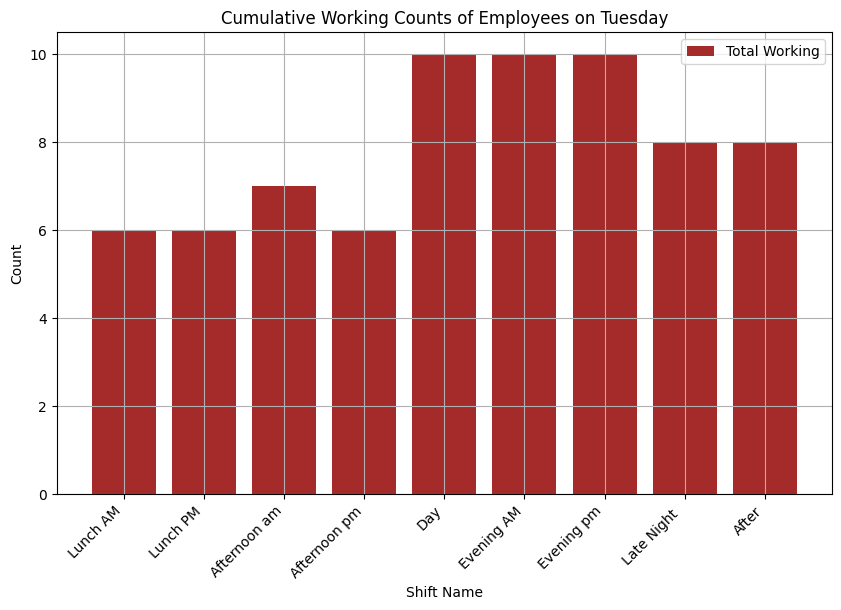

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Your data
ns_output = pd.DataFrame()
ns_output['Shift No.'] = ns.ft.get_values().keys()
ns_output['Min Required'] = [x+y for x, y in zip(z_ft, z_pt)]
ft = list(ns.ft.get_values().values())
pt1 = list(ns.pt1.get_values().values())
pt2 = list(ns.pt2.get_values().values())
pt3 = list(ns.pt3.get_values().values())

# Calculate the number of people currently working a shift
ns_output['FT Working'] = [sum(ft[max(0, z-3):z+1]) if z <= 7 else sum(ft[max(0, z-4):z+1]) for z in range(len(ft))]
ns_output['PT1 Working'] = [sum(pt1[max(0, z-0):z+1]) for z in range(len(pt1))]
ns_output['PT2 Working'] = [sum(pt2[max(0, z-1):z+1]) for z in range(len(pt2))]
ns_output['PT3 Working'] = [sum(pt3[max(0, z-2):z+1]) for z in range(len(pt3))]
ns_output['total'] = ns_output['FT Working'] + ns_output['PT1 Working'] + ns_output['PT2 Working'] + ns_output['PT3 Working']
# shift names
df_ratio = pd.read_excel('Papa Johns Demand.xlsx', sheet_name='Ratios')
df_ratio = df_ratio.drop(df_ratio.index[10:], axis=0)
df_shifts = df_ratio
df_shifts = df_shifts.iloc[:,:1]
ns_output['Shift Name'] = list(df_shifts.loc[1:,'Shift Name'])

grace_variable = ns_output['total']

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(ns_output['Shift Name'], ns_output['total'], label='Total Working', color=['brown'])
plt.xlabel('Shift Name')
plt.ylabel('Count')
plt.title('Cumulative Working Counts of Employees on ' + day)
plt.legend()
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


#### No of Staff working in Shift i vs Demand

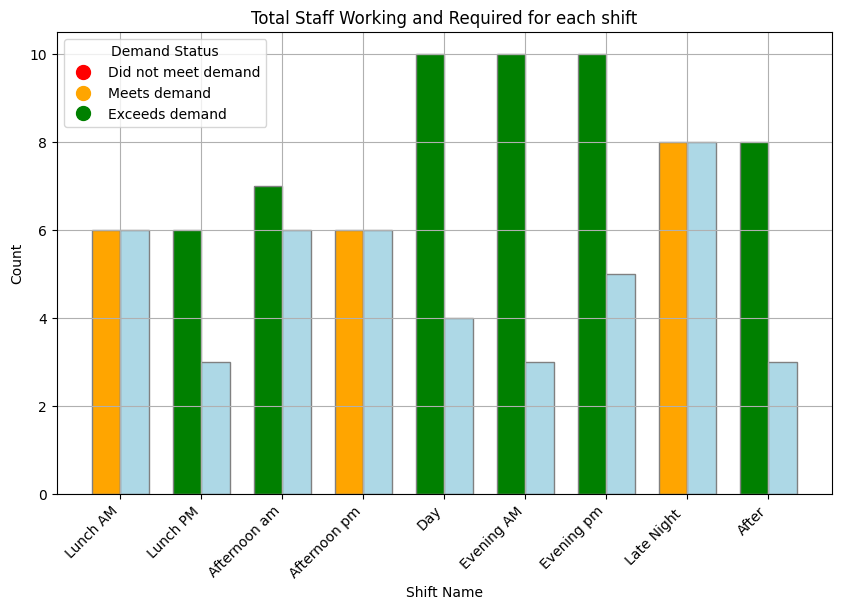

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Your data
# Assuming ns_output, z_ft, z_pt, ft, pt1, pt2, pt3, df_ratio, df_shifts, day, and rec_shift_req are defined

ns_output['Min Required'] = [x + y for x, y in zip(z_ft, z_pt)]
ns_output['FT Working'] = [sum(ft[max(0, z-3):z+1]) if z <= 7 else sum(ft[max(0, z-4):z+1]) for z in range(len(ft))]
ns_output['PT1 Working'] = [sum(pt1[max(0, z-0):z+1]) for z in range(len(pt1))]
ns_output['PT2 Working'] = [sum(pt2[max(0, z-1):z+1]) for z in range(len(pt2))]
ns_output['PT3 Working'] = [sum(pt3[max(0, z-2):z+1]) for z in range(len(pt3))]
ns_output['total'] = ns_output['FT Working'] + ns_output['PT1 Working'] + ns_output['PT2 Working'] + ns_output['PT3 Working']
ns_output['total_req'] = rec_shift_req[day]
ns_output['Shift Name'] = list(df_shifts.loc[1:, 'Shift Name'])

# Create numerical representation for x-axis ticks
shift_values = np.arange(len(ns_output['Shift Name']))

plt.figure(figsize=(10, 6))
width = 0.35

# Determine the colors and labels based on the conditions
colors = ['green' if total_val > total_req_val else ('orange' if total_val == total_req_val else 'red')
          for total_val, total_req_val in zip(ns_output['total'], ns_output['total_req'])]

colors1 = ['red' if total_val < total_req_val else '#ADD8E6'
          for total_val, total_req_val in zip(ns_output['total'], ns_output['total_req'])]

legend_labels = {'red': 'Did not meet demand', 'orange': 'Meets demand', 'green': 'Exceeds demand'}

# Plot the bars with the determined colors
bar1 = plt.bar(shift_values - width/2, ns_output['total'], width, label='Total Working', color=colors, edgecolor='grey')
bar2 = plt.bar(shift_values + width/2, ns_output['total_req'], width, label='Total Required', color=colors1, edgecolor='grey')

# Create a legend for the color map
legend_handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', markersize=10, label=label)
                  for color, label in legend_labels.items()]

plt.legend(handles=legend_handles, title='Demand Status', loc='upper left')

plt.xlabel('Shift Name')
plt.ylabel('Count')
plt.title('Total Staff Working and Required for each shift')
plt.xticks(shift_values, ns_output['Shift Name'], rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


#### No of Staff starting Shift i

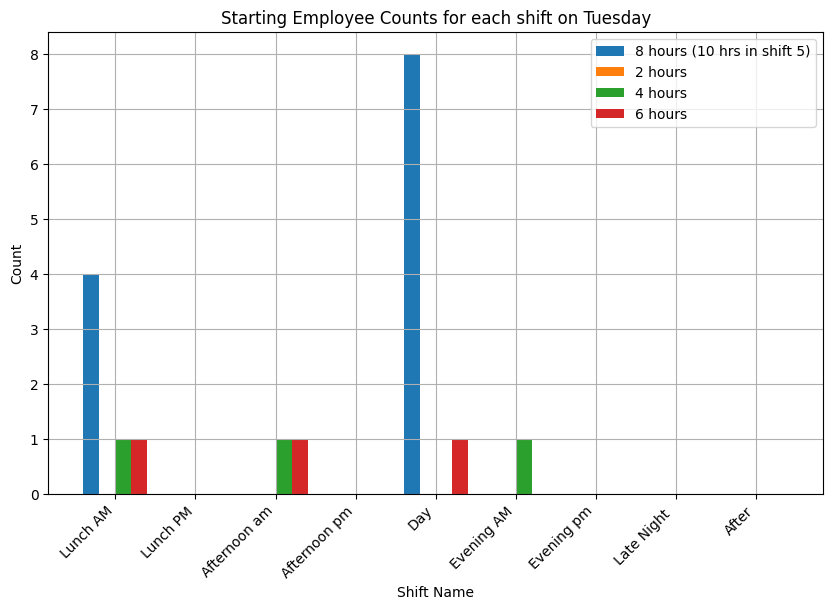

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Your data
# Assuming ns_output, z_ft, z_pt, ft, pt1, pt2, pt3, df_ratio, df_shifts, and day are defined

ns_output['Min Required'] = [x + y for x, y in zip(z_ft, z_pt)]
ns_output['FT Starting'] = [int(ft[z]) for z in range(len(ft))]
ns_output['PT1 Starting'] = [int(pt1[z]) for z in range(len(pt1))]
ns_output['PT2 Starting'] = [int(pt2[z]) for z in range(len(pt2))]
ns_output['PT3 Starting'] = [int(pt3[z]) for z in range(len(pt3))]

# Create a bar chart
plt.figure(figsize=(10,6))

bar_width = 0.2  # Adjust the width of the bars

# Plotting the bars
plt.bar(shift_values - 1.5 * bar_width, ns_output['FT Starting'], width=bar_width, label='8 hours (10 hrs in shift 5)')
plt.bar(shift_values - 0.5 * bar_width, ns_output['PT1 Starting'], width=bar_width, label='2 hours')
plt.bar(shift_values + 0.5 * bar_width, ns_output['PT2 Starting'], width=bar_width, label='4 hours')
plt.bar(shift_values + 1.5 * bar_width, ns_output['PT3 Starting'], width=bar_width, label='6 hours')

plt.xlabel('Shift Name')
plt.ylabel('Count')
plt.title('Starting Employee Counts for each shift on ' + day)
plt.legend()
plt.xticks(shift_values, shift_names, rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


### 06. Ratio Split - Insiders/Driver

#### Ratio Code

In [18]:
#RATIO work
df_ratio = pd.read_excel('Papa Johns Demand.xlsx', sheet_name='Ratios')
df_ratio = df_ratio.drop(df_ratio.index[10:], axis=0)
df_shifts = df_ratio
df_shifts = df_shifts.iloc[:,:2]
#df_ratio

# Iterate through the columns and merge headers
columns = df_ratio.columns
merged_columns = []
current_day = None
counter = 1

for column in columns:
    if 'Unnamed' in column:
        if current_day is None:
            current_day = column.split(': ')[0]
        else:
            current_day += f"_{counter}"
            counter += 1
    else:
        current_day = column
        counter = 1
    merged_columns.append(current_day)

# Update the DataFrame with the merged column headers
df_ratio.columns = merged_columns

# Update table to the day we are interested in
column_index = df_ratio.columns.get_loc(day)
df_ratio = df_ratio.iloc[:,column_index:column_index+3]
df_ratio

,Tuesday,Tuesday_1,Tuesday_1_2
0,Drivers,Insiders,Sum
1,2,5.8,7.8
2,0.5,0.466667,0.966667
3,0.5,0.466667,0.966667
4,3,6,9
5,2.75,3.866667,6.616667
6,2.75,1.533333,4.283333
7,4.5,1.933333,6.433333
8,3.25,1.066667,4.316667
9,NaN,NaN,NaN


In [19]:
# Create the ratio column, delete others
df_ratio[f'{day} Driver Ratio (%)'] = (df_ratio[day].iloc[1:] / df_ratio[f'{day}_1_2'].iloc[1:])*100
df_ratio = df_ratio.drop(df_ratio.columns[:3], axis=1)
#df_ratio

# Add back 'shift name' and 'time'
df_ratio = pd.concat([df_shifts, df_ratio], axis=1)

# Drop empty first row
df_ratio = df_ratio.drop(0)

# Reset index
df_ratio = df_ratio.reset_index(drop=True)
df_ratio

,Shift Name,Time,Tuesday Driver Ratio (%)
0,Lunch AM,10:00 am - 11:59 am,25.641026
1,Lunch PM,12:00 pm - 1:59 pm,51.724138
2,Afternoon am,2:00 pm - 3:59 pm,51.724138
3,Afternoon pm,4:00 pm - 5:59 pm,33.333333
4,Day,6:00 pm - 7:59 pm,41.561713
5,Evening AM,8:00 pm - 9:59 pm,64.202335
6,Evening pm,10:00 pm - 11:59 pm,69.948187
7,Late Night,12:00 am - 1:59 am,75.289575
8,After,2:00 am - 3:59 am,NaN


In [20]:
import math

df_ratio = pd.concat([df_ratio,grace_variable], axis=1)
df_ratio

,Shift Name,Time,Tuesday Driver Ratio (%),total
0,Lunch AM,10:00 am - 11:59 am,25.641026,6.0
1,Lunch PM,12:00 pm - 1:59 pm,51.724138,6.0
2,Afternoon am,2:00 pm - 3:59 pm,51.724138,7.0
3,Afternoon pm,4:00 pm - 5:59 pm,33.333333,6.0
4,Day,6:00 pm - 7:59 pm,41.561713,10.0
5,Evening AM,8:00 pm - 9:59 pm,64.202335,10.0
6,Evening pm,10:00 pm - 11:59 pm,69.948187,10.0
7,Late Night,12:00 am - 1:59 am,75.289575,8.0
8,After,2:00 am - 3:59 am,NaN,8.0


In [21]:
df_ratio['Drivers'] = (df_ratio['total']/100) * df_ratio[f'{day} Driver Ratio (%)']

# NaN's skipped
df_ratio['Driver Count'] = df_ratio['Drivers'].apply(lambda x: math.ceil(x) if pd.notna(x) else x)

# Insiders
df_ratio['Insider Count'] = df_ratio['total'] - df_ratio['Driver Count']
df_ratio['Insider Count'] = df_ratio['Insider Count'].apply(lambda x: math.ceil(x)if pd.notna(x) else x)

df_ratio

,Shift Name,Time,Tuesday Driver Ratio (%),total,Drivers,Driver Count,Insider Count
0,Lunch AM,10:00 am - 11:59 am,25.641026,6.0,1.538462,2.0,4.0
1,Lunch PM,12:00 pm - 1:59 pm,51.724138,6.0,3.103448,4.0,2.0
2,Afternoon am,2:00 pm - 3:59 pm,51.724138,7.0,3.62069,4.0,3.0
3,Afternoon pm,4:00 pm - 5:59 pm,33.333333,6.0,2.0,2.0,4.0
4,Day,6:00 pm - 7:59 pm,41.561713,10.0,4.156171,5.0,5.0
5,Evening AM,8:00 pm - 9:59 pm,64.202335,10.0,6.420233,7.0,3.0
6,Evening pm,10:00 pm - 11:59 pm,69.948187,10.0,6.994819,7.0,3.0
7,Late Night,12:00 am - 1:59 am,75.289575,8.0,6.023166,7.0,1.0
8,After,2:00 am - 3:59 am,NaN,8.0,NaN,NaN,NaN


#### Ratio Visual

C:\Users\arun9\AppData\Local\Temp\ipykernel_13084\3837396144.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, df_plot['Driver Count'][i] + insider / 2, str(insider), ha='center', va='center', color='white')


<Figure size 1000x600 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values


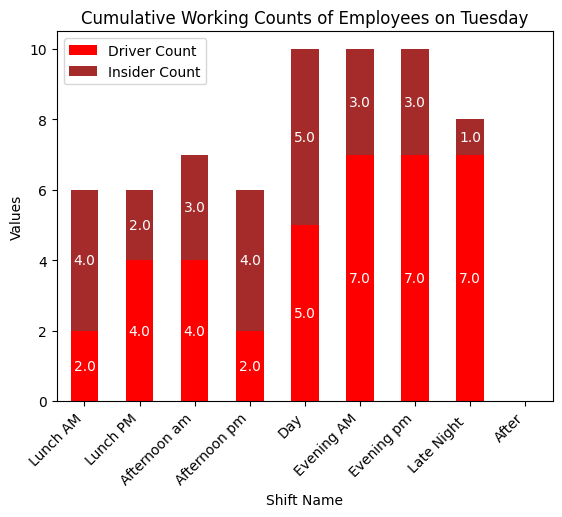

In [22]:
#Visualize
import pandas as pd
import matplotlib.pyplot as plt

# Selecting only the relevant columns for the bar graph
df_plot = df_ratio[['Shift Name', 'Driver Count', 'Insider Count']]

# Setting 'Shift Name' as the index for plotting
df_plot.set_index('Shift Name', inplace=True)
plt.figure(figsize=(10, 6))
# Plotting
ax = df_plot.plot(kind='bar', stacked=True, color=['red', 'brown'])

# Plot 'Drivers' bars with counts
ax.bar(9,df_plot['Driver Count'], width=0.2)
for i, driver in enumerate(df_plot['Driver Count']):
    ax.text(i, driver / 2, str(driver), ha='center', va='center', color='white')

# Plot 'Insiders' bars with counts on top of 'Drivers'
ax.bar(9,df_plot['Insider Count'], width=0.2, bottom=df_plot['Driver Count'])
for i, insider in enumerate(df_plot['Insider Count']):
    ax.text(i, df_plot['Driver Count'][i] + insider / 2, str(insider), ha='center', va='center', color='white')
    
# Setting labels and title
plt.xlabel('Shift Name')
plt.ylabel('Values')
plt.title('Cumulative Working Counts of Employees on ' + day)

# Display the legend
plt.legend()
# plt.grid(True)
# Show the plot
plt.xticks(rotation=45, ha="right")
plt.show()

# THE END